1.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [3]:
# Load audio file
file_path = r"C:\Users\sanja\Downloads\SPR TIMIT\Data\Audio\Male\TMIT\SX6.wav"  
signal, sample_rate = sf.read(file_path)

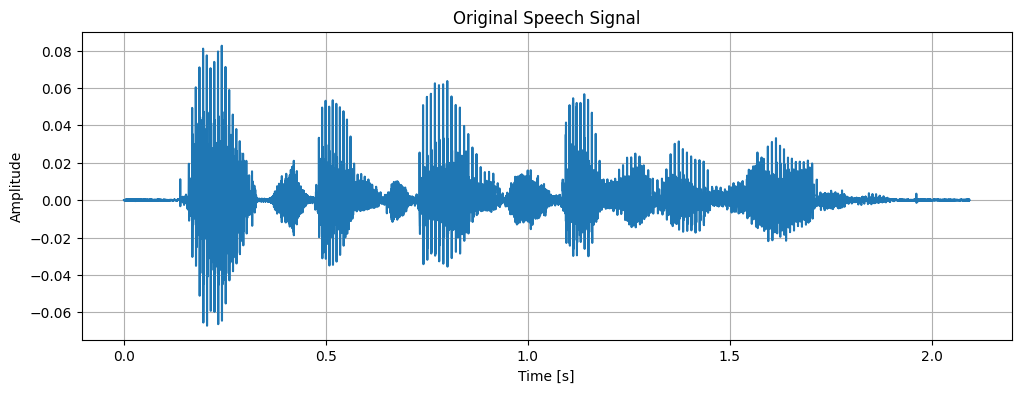

In [4]:
# a) Plot the original speech signal
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, len(signal) / sample_rate, num=len(signal)), signal)
plt.title('Original Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

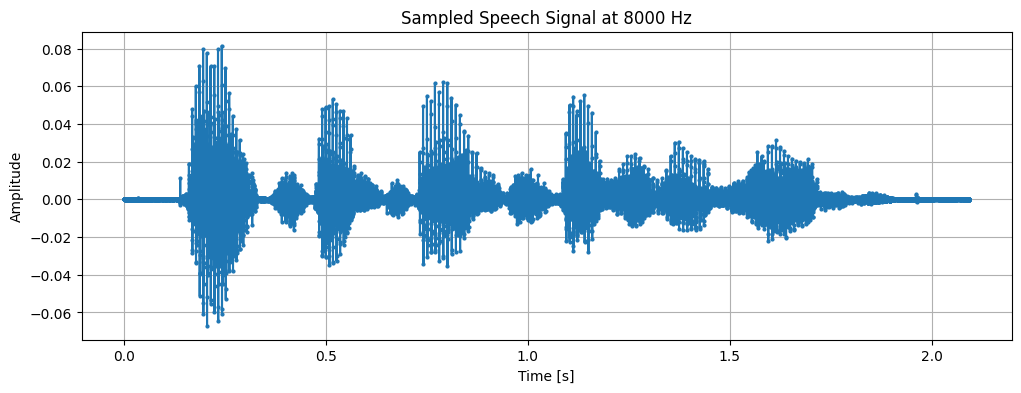

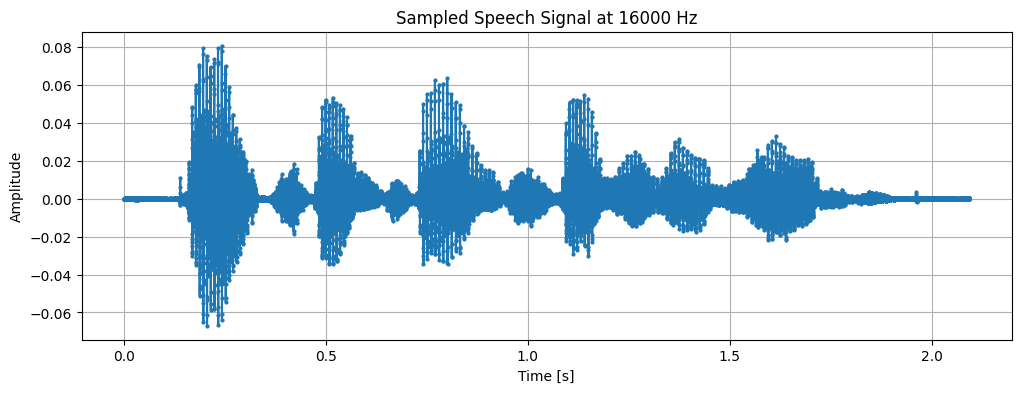

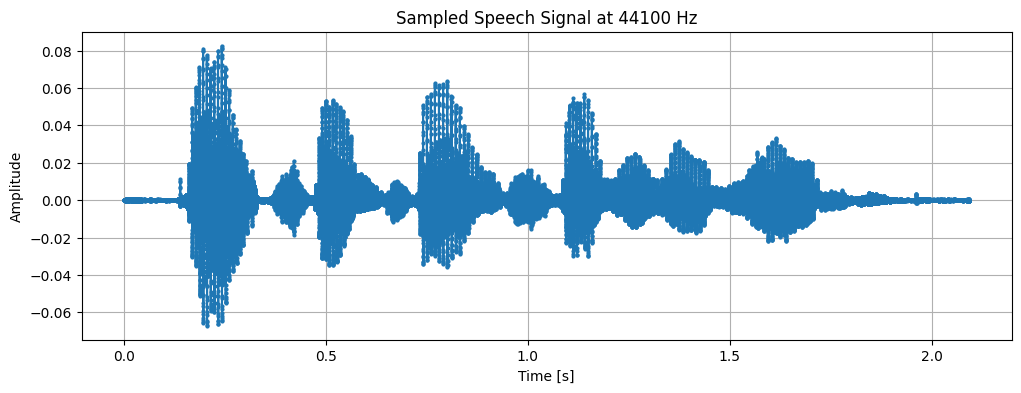

In [6]:
# b) Sample the speech signal at different rates
sampling_rates = [8000, 16000, 44100]
sampled_signals = []
time_orig = np.linspace(0, len(signal) / sample_rate, num=len(signal))

for rate in sampling_rates:
    indices = np.round(np.linspace(0, len(signal)-1, num=int(rate * len(signal) / sample_rate))).astype(int)
    sampled_signals.append(signal[indices])
    time_sampled = np.linspace(0, len(sampled_signals[-1]) / rate, num=len(sampled_signals[-1]))
    # c) Plot sampled speech signal
    plt.figure(figsize=(12, 4))
    plt.plot(time_sampled, sampled_signals[-1], marker='o', linestyle='-', markersize=2)
    plt.title(f'Sampled Speech Signal at {rate} Hz')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()


In [7]:
# d) Reconstruct the signal using zero-order hold and linear interpolation
reconstructed_signals_zero_order = []
reconstructed_signals_linear = []

for sampled_signal, rate in zip(sampled_signals, sampling_rates):
    # Zero-order hold (nearest-neighbor interpolation)
    time_sampled = np.linspace(0, len(sampled_signal) / rate, num=len(sampled_signal))
    # Repeat each sampled value
    zero_order_reconstructed = np.repeat(sampled_signal, int(sample_rate / rate))
    reconstructed_signals_zero_order.append(zero_order_reconstructed[:len(signal)])

    # Linear interpolation
    f_linear = interp1d(time_sampled, sampled_signal, kind='linear', fill_value='extrapolate')
    time_orig_reconstructed = np.linspace(0, len(signal) / sample_rate, num=len(signal))
    linear_reconstructed = f_linear(time_orig_reconstructed)
    reconstructed_signals_linear.append(linear_reconstructed)

In [9]:
# e) Calculate Mean Squared Error (MSE)
for i in range(len(sampling_rates)):
    # Ensure the lengths match for calculation
    zero_order_length = min(len(signal), len(reconstructed_signals_zero_order[i]))
    linear_length = min(len(signal), len(reconstructed_signals_linear[i]))

    mse_zero_order = mean_squared_error(signal[:zero_order_length], reconstructed_signals_zero_order[i][:zero_order_length])
    mse_linear = mean_squared_error(signal[:linear_length], reconstructed_signals_linear[i][:linear_length])
    
    print(f"MSE for {sampling_rates[i]} Hz - Zero-order Hold: {mse_zero_order}, Linear Interpolation: {mse_linear}")

MSE for 8000 Hz - Zero-order Hold: 0.0001286288354647742, Linear Interpolation: 2.241398360716951e-06
MSE for 16000 Hz - Zero-order Hold: 0.0001351302511333216, Linear Interpolation: 1.5618425744102834e-06
MSE for 44100 Hz - Zero-order Hold: 0.0, Linear Interpolation: 1.0009793454332375e-39


2.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, firwin
from sklearn.metrics import mean_squared_error

(a) Source-Filter Model
(i) Create a Source Signal:

Here, we create a glottal pulse train for voiced sounds.

In [11]:
def create_source_signal(frequency=100, duration=1, fs=44100):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    source = 0.5 * (1 + np.sign(np.sin(2 * np.pi * frequency * t)))  # Glottal pulse train
    return source, fs

(ii) Apply a Filter:

Create an all-pole filter to model the vocal tract.




In [12]:
def apply_filter(source, fs):
    # Design a vocal tract filter (5 formants)
    formants = [0.5, 1.0, 2.2, 3.5, 5.0]  # Normalized frequencies
    b = firwin(60, formants, window='hamming', fs=fs)
    filtered_signal = lfilter(b, 1, source)  # Apply filter
    return filtered_signal

Generate the Synthetic Speech Signal:

In [13]:
fs = 44100
source_signal, fs = create_source_signal(frequency=100, duration=1, fs=fs)
speech_signal = apply_filter(source_signal, fs)

(b) Plot the Generated Speech Signal:

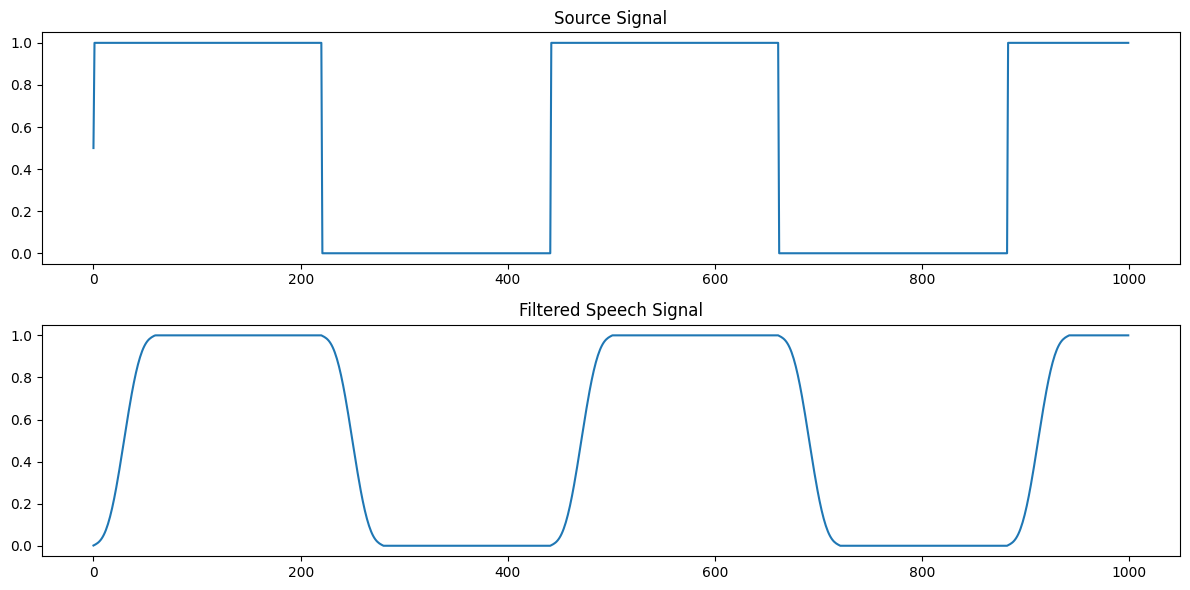

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("Source Signal")
plt.plot(source_signal[:1000])  # Plot first 1000 samples
plt.subplot(2, 1, 2)
plt.title("Filtered Speech Signal")
plt.plot(speech_signal[:1000])  # Plot first 1000 samples
plt.tight_layout()
plt.show()

In [22]:
import sounddevice as sd

sd.play(speech_signal, fs)
sd.wait()  # Wait until the sound has finished playing

(c) Sample the Speech Signal at Different Rates:

In [18]:
def sample_signal(signal, original_rate, new_rate):
    sample_indices = np.arange(0, len(signal), original_rate / new_rate)
    return signal[np.round(sample_indices).astype(int)]

sampling_rates = [8000, 16000, 44100]
sampled_signals = {rate: sample_signal(speech_signal, fs, rate) for rate in sampling_rates}

(d) Reconstruct the Signal:

Here we can implement both zero-order hold and linear interpolation for reconstruction.

In [19]:
from scipy.interpolate import interp1d

def reconstruct_signal(signal, original_rate, new_rate, method='linear'):
    original_time = np.arange(len(signal)) / original_rate
    new_time = np.arange(0, len(signal), original_rate / new_rate) / new_rate

    if method == 'linear':
        interpolator = interp1d(original_time, signal, kind='linear', fill_value='extrapolate')
        reconstructed = interpolator(new_time)
    else:  # zero-order hold
        reconstructed = np.repeat(signal, original_rate // new_rate)
        reconstructed = reconstructed[:len(new_time)]  # truncate to new length
    return reconstructed

In [20]:
for rate in sampling_rates:
    reconstructed_signal = reconstruct_signal(sampled_signals[rate], rate, fs, method='linear')
    mse = mean_squared_error(speech_signal[:len(reconstructed_signal)], reconstructed_signal)
    print(f"MSE for {rate} Hz: {mse}")

MSE for 8000 Hz: 0.44069711898910696
MSE for 16000 Hz: 0.44046571915722466
MSE for 44100 Hz: 0.0
